We have access to a specific bank loan data. We have data about all loans asked to the bank, whether the bank decided to grant it and, finally, whether the borrower managed to repay it. We also have info about the borrower at the moment she is asking for the loan.

In [121]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
    
from matplotlib.legend_handler import HandlerLine2D

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from __future__ import print_function
import graphviz

%matplotlib inline

# Load Dataset

In [2]:
loan = pd.read_csv('../DS_Challenges/Loan_Granting/loan_table.csv')
borrower = pd.read_csv('../DS_Challenges/Loan_Granting/borrower_table.csv')

In [3]:
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [4]:
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   loan_id       101100 non-null  int64  
 1   loan_purpose  101100 non-null  object 
 2   date          101100 non-null  object 
 3   loan_granted  101100 non-null  int64  
 4   loan_repaid   47654 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [6]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

# Question 1

Build a model which is better than the bank model. For simplicity, assume that:

    - If you grant the loan and the it doesn't get repaid, you lose 1
    - If you grant the loan and the it does get repaid, you gain 1
    - If you don't grant the loan, you gain 0
  

Using the rules above, compare bank profitability vs your model profitability

In [7]:
loan['date'] = pd.to_datetime(loan.date)

In [8]:
data = loan.merge(borrower, on = 'loan_id')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  object        
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   is_first_loan                                    101100 non-null  int64         
 6   fully_repaid_previous_loans                      46153 non-null   float64       
 7   currently_repaying_other_loans                   46153 non-null   float64       
 8   total_credit_card_limit 

In [10]:
# choose data with loan granted 
# the data with loan not granted is not useful for profit calculation
data = data[data['loan_granted'] == 1]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit            

## initial modelling without feature engineering

In [9]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+8-b765.1); OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from /Users/yli/opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmptovjf9iv
  JVM stdout: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmptovjf9iv/h2o_yli_started_from_python.out
  JVM stderr: /var/folders/df/669jwmvs7m78zz36wmxbr_zm0000gn/T/tmptovjf9iv/h2o_yli_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_yli_uruy5n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [12]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
data.info()

Parse progress: |█████████████████████████████████████████████████████████| 100%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   loan_purpose                                     101100 non-null  object 
 2   date                                             101100 non-null  object 
 3   loan_granted                                     101100 non-null  int64  
 4   loan_repaid                                      47654 non-null   float64
 5   is_first_loan                                    101100 non-null  int64  
 6   fully_repaid_previous_loans                      46153 non-null   float64
 7   currently_repaying_other_loans                   46153 non-null   float64
 8   total_credit_

In [13]:
# change to categorical variables
h2o_df['loan_granted'] = h2o_df['loan_granted'].asfactor()
h2o_df['is_first_loan'] = h2o_df['is_first_loan'].asfactor()
h2o_df['fully_repaid_previous_loans'] = h2o_df['fully_repaid_previous_loans'].asfactor()
h2o_df['currently_repaying_other_loans'] = h2o_df['currently_repaying_other_loans'].asfactor()
h2o_df['is_employed'] = h2o_df['is_employed'].asfactor()

h2o_df.summary()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
type,int,enum,time,enum,enum,enum,enum,enum,int,real,int,int,enum,int,int,int
mins,30.0,,1325462400000.0,,,,,,0.0,0.0,0.0,0.0,,0.0,18.0,0.0
mean,499666.8267260164,,1341022408451.0457,,,,,,4112.743818001983,0.7241396821349663,1799.617616221567,3177.150820969348,,21020.72799208714,41.49163204747762,3.8647477744807226
maxs,999987.0,,1356652800000.0,,,,,,13500.0,1.09,10641.0,13906.0,,97200.0,79.0,8.0
sigma,288662.0069285392,,9070558460.709177,,,,,,2129.121462019133,0.18648306602295645,1400.545140731874,2044.448154632104,,18937.58141515658,12.825569638708254,2.635490684139471
zeros,0,,0,,,,,,6972,2,8,2,,34521,0,3432
missing,0,0,0,0,0,0,0,0,0,6972,0,0,0,0,0,0
0,19454.0,investment,2012-03-15 00:00:00,0,nan,1,nan,nan,8600.0,0.79,1491.0,6285.0,1,45200.0,42.0,7.0
1,496811.0,investment,2012-01-17 00:00:00,0,nan,1,nan,nan,5300.0,0.52,141.0,5793.0,0,0.0,42.0,5.0
2,929493.0,other,2012-02-09 00:00:00,0,nan,1,nan,nan,0.0,nan,660.0,3232.0,1,26500.0,60.0,4.0


In [15]:
h2o_df.columns

['loan_id',
 'loan_purpose',
 'date',
 'loan_granted',
 'loan_repaid',
 'is_first_loan',
 'fully_repaid_previous_loans',
 'currently_repaying_other_loans',
 'total_credit_card_limit',
 'avg_percentage_credit_card_limit_used_last_year',
 'saving_amount',
 'checking_amount',
 'is_employed',
 'yearly_salary',
 'age',
 'dependent_number']

In [19]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['loan_granted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['loan_purpose',
 'is_first_loan',
 'fully_repaid_previous_loans',
 'currently_repaying_other_loans',
 'total_credit_card_limit',
 'avg_percentage_credit_card_limit_used_last_year',
 'saving_amount',
 'checking_amount',
 'is_employed',
 'yearly_salary',
 'age',
 'dependent_number']

target = 'loan_granted'


# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20,
                                 mtries=-1, seed=42, score_each_iteration=True)

model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


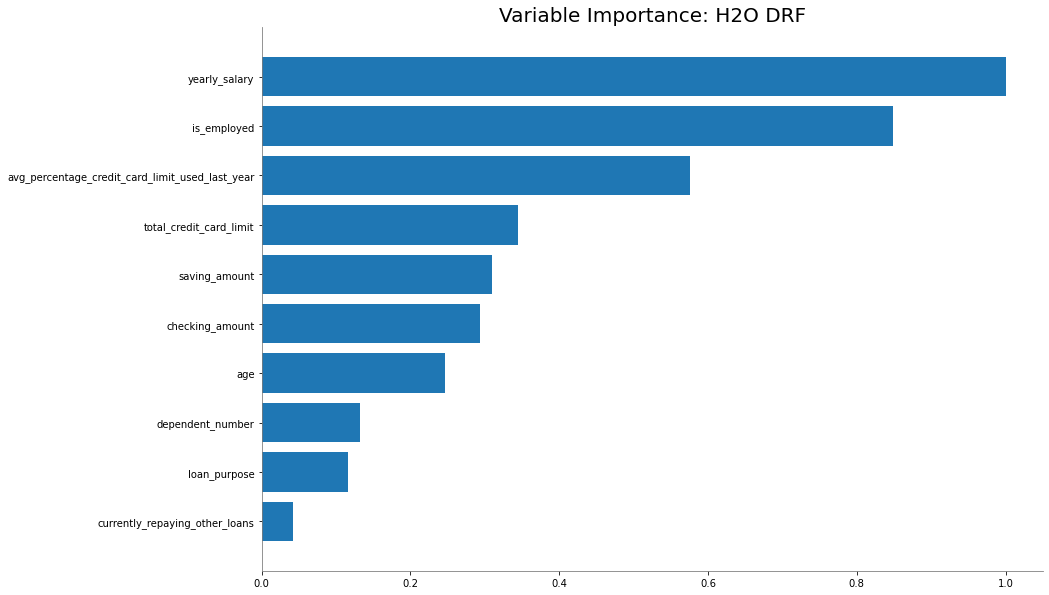

In [20]:
# variable importance plot
model.varimp_plot()

In [21]:
# Feature importance
importance = model.varimp(use_pandas=True)

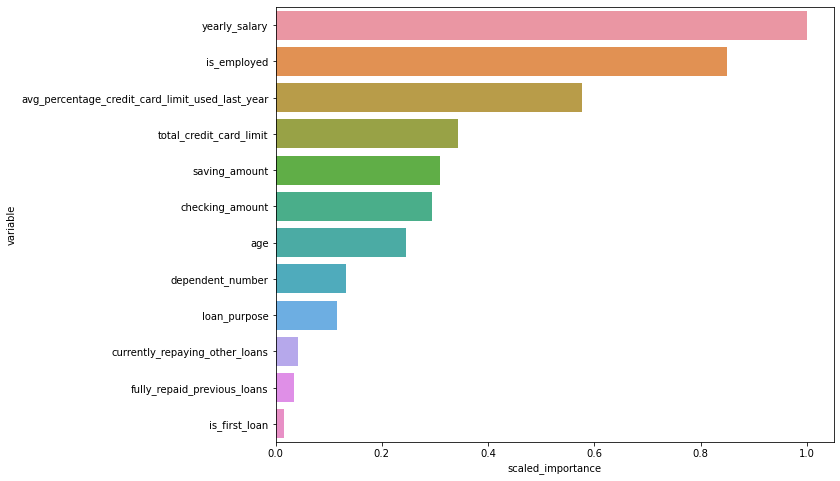

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [24]:
# Make predictions
train_true = train.as_data_frame()['loan_granted'].values
test_true = test.as_data_frame()['loan_granted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.87      0.68      0.77     13362
           1       0.71      0.89      0.79     11914

    accuracy                           0.78     25276
   macro avg       0.79      0.78      0.78     25276
weighted avg       0.80      0.78      0.78     25276



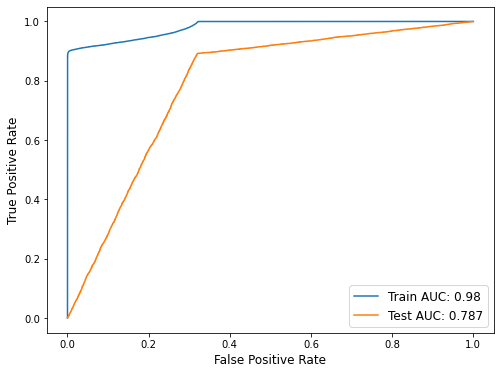

In [25]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

# AUC plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


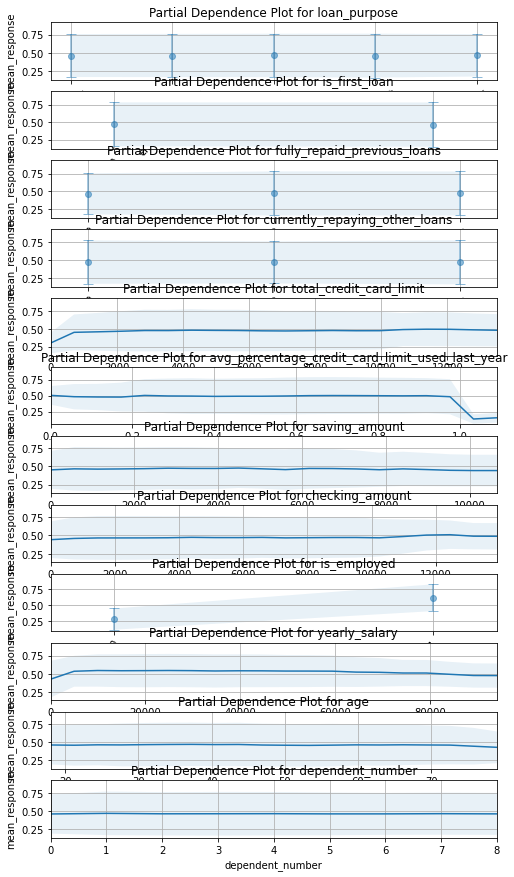

In [26]:
# partial_plot
## the blue block represents the confidence interval
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

## initial comparison

In [43]:
type(test)

h2o.frame.H2OFrame

In [48]:
test_df = h2o.as_list(test)

In [50]:
type(test_df)

pandas.core.frame.DataFrame

In [53]:
# The profitability of Bank's model
test_df.loc[(test_df['loan_granted']==1)&(test_df['loan_repaid']==1)].shape[0]-test_df.loc[(test_df['loan_granted']==1)&(test_df['loan_repaid']==0)].shape[0]

3488

In [56]:
test_predict_mymodel = model.predict(test).as_data_frame()['predict']
type(test_predict_mymodel)

drf prediction progress: |████████████████████████████████████████████████| 100%


pandas.core.series.Series

In [58]:
test_mine = test_df.copy()
del test_mine['loan_granted']
test_mine['loan_granted'] = test_predict_mymodel

In [59]:
test_mine

,loan_id,loan_purpose,date,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_granted
0,77085,other,1346371200000,NaN,1,NaN,NaN,3000,0.82,1028,3269,0,0,45,3,0
1,303138,emergency_funds,1346371200000,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2,0
2,484791,investment,1341878400000,NaN,1,NaN,NaN,5100,0.73,4923,9067,1,13600,33,2,1
3,751153,home,1355788800000,1.0,0,1.0,0.0,4600,0.85,1915,8509,1,79700,58,3,1
4,584158,investment,1328659200000,NaN,0,1.0,0.0,7500,0.62,861,3973,0,0,37,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,382682,business,1347926400000,1.0,0,1.0,0.0,7000,0.43,1207,1882,1,44400,40,4,1
25272,316509,investment,1344988800000,1.0,1,NaN,NaN,2600,0.90,2241,2673,1,32100,55,4,1
25273,981107,home,1346976000000,1.0,0,1.0,0.0,6900,0.86,3943,9302,1,21800,48,8,1
25274,628418,home,1326844800000,NaN,1,NaN,NaN,0,NaN,1581,1454,1,21500,40,8,0


In [61]:
# The profitability of my model
test_mine.loc[(test_mine['loan_granted']==1)&(test_mine['loan_repaid']==1)].shape[0]-test_mine.loc[(test_mine['loan_granted']==1)&(test_mine['loan_repaid']==0)].shape[0]

4223

As we can see from above number that 4223 is bigger than 3488, thus my initial model earns more and is already better than bank's model.

In [62]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_9d9b closed.


## QUESTION 2

Describe the impact of the most important variables on the prediction. Also, focus on the variable "is_employed", which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why

As we can see from the plot below that, the most important variable is `yearly_salary`.

The variable `is_employed` is the second important variable to the model which means it's very important.

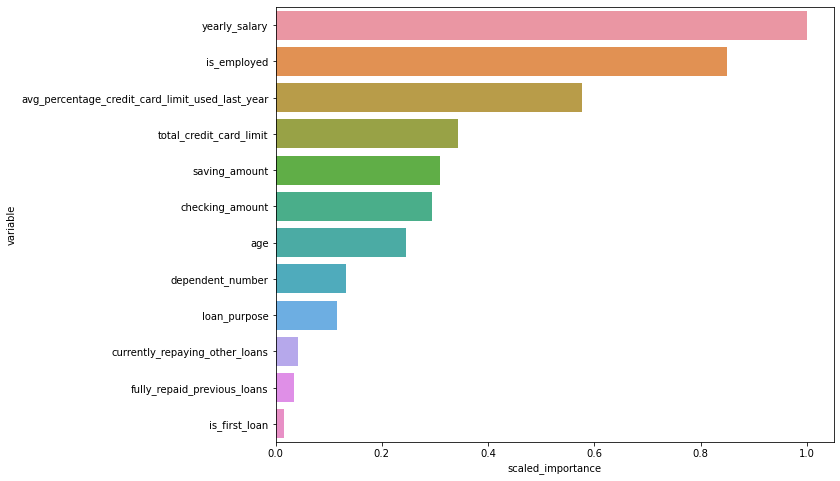

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

<AxesSubplot:xlabel='loan_granted', ylabel='yearly_salary'>

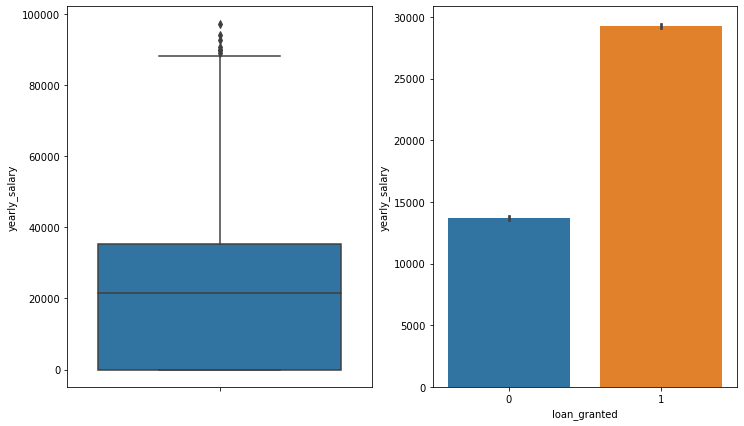

In [74]:
## let's dig more
## It's clear that tne bank grant loan much more to those have a high yearly-salary
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,7))
sns.boxplot(data = data, y = 'yearly_salary',ax = ax[0])
sns.barplot(data = data, y = 'yearly_salary',x = 'loan_granted',ax = ax[1])

## QUESTION 3

Are there any other variables, not in the data provided, that you'd have liked to include in
the model?

The following variables could be added to the model:

    Number of open accounts
    Total available credit
    Average (payment/amount due)
    Maximum delinquency past 24 months
    Ever bankrupt?
    Age of oldest open account
    Length of residence
    Own/rent
    Cash advances over past 12 months
    Mortgage LTV…

# Improved Framework

## Feature engineering

### Leave out the unnecessary features

1. As we can see below that if the borrower is NOT employed, then their salary is 0, which do make sense. However, there're some borrowers whose salary is 0 but they are employed. Since the number of these borrowers is not so large so I decide to leave them. Meanwhile, since `is_employed` and `yearly_salary` nearly represent the same meaning since if someone is employed then his or her salary will be mostly greater than 0, otherwise his salary is 0. Therefore, we could remove one of these two variables, I choose to remove `is_employed`.

2. We also have some missing values in `fully_repaid_previous_loans` and `currently_repaying_other_loans`, which represent situations that borrowers take this as the first loan. Thus I will replace NAN with '-1' which represents the first loan.

In [11]:
data.loc[data['is_employed']==0,'yearly_salary'].value_counts()

0    4297
Name: yearly_salary, dtype: int64

In [12]:
data.loc[(data['is_employed']==1)&(data['yearly_salary']==0)]

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
12230,830900,other,2012-05-03,1,1.0,0,1.0,0.0,6500,0.73,2902,3646,1,0,49,1
14402,155108,investment,2012-10-02,1,1.0,1,NaN,NaN,4800,0.69,3062,2220,1,0,31,1
19273,705528,business,2012-02-21,1,1.0,1,NaN,NaN,4100,0.58,2603,6074,1,0,33,0
24062,793669,investment,2012-01-12,1,1.0,1,NaN,NaN,9400,0.77,1552,5119,1,0,68,5
32193,657937,investment,2012-09-21,1,1.0,1,NaN,NaN,6500,0.43,271,4007,1,0,49,1
73726,828379,other,2012-04-25,1,1.0,1,NaN,NaN,1900,0.79,2753,2916,1,0,52,2
79012,139144,other,2012-10-17,1,0.0,1,NaN,NaN,2200,0.70,1807,2976,1,0,20,2
80039,632587,other,2012-06-19,1,0.0,1,NaN,NaN,4300,0.77,1345,2056,1,0,28,3
94163,416825,business,2012-01-11,1,1.0,0,1.0,0.0,5400,0.71,357,1737,1,0,69,1


In [13]:
# remove column 'is_employed'
data.drop(columns = 'is_employed', inplace = True)
data.head(3)

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,34800,31,4
6,780070,business,2012-03-14,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,51100,51,2


In [14]:
# replace nan in fully_repaid_previous_loans and currently_repaying_other_loans
data = data.fillna({'fully_repaid_previous_loans':-1,'currently_repaying_other_loans':-1})

# redundant after filling missing in 'fully_repaid_previous_loans' and 'currently_repaying_other_loans'
del data['is_first_loan']

In [15]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

Since we only care about whether or not borrowers will pay the loan after granting loan, I decide to remove `loan_granted` which is redundant with `loan_repaid`.

In [16]:
# drop useless features
data.drop(columns=['loan_id', 'date', 'loan_granted'], inplace = True)

In [17]:
data

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number
3,other,1.0,1.0,0.0,5400,0.52,3345,2764,15800,58,4
4,business,0.0,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4
6,business,1.0,1.0,0.0,7800,0.30,4206,4368,51100,51,2
7,emergency_funds,0.0,0.0,1.0,4300,1.02,886,1597,15000,59,2
8,investment,1.0,1.0,0.0,3900,0.65,1837,3795,12000,24,1
...,...,...,...,...,...,...,...,...,...,...,...
101094,business,0.0,1.0,1.0,2600,0.83,1019,537,37100,37,4
101095,emergency_funds,0.0,1.0,0.0,2400,0.40,553,2372,37000,56,3
101096,business,0.0,-1.0,-1.0,3100,0.68,367,1957,22700,59,5
101097,other,1.0,-1.0,-1.0,4600,0.50,1134,1621,35200,49,1


### feature correlation

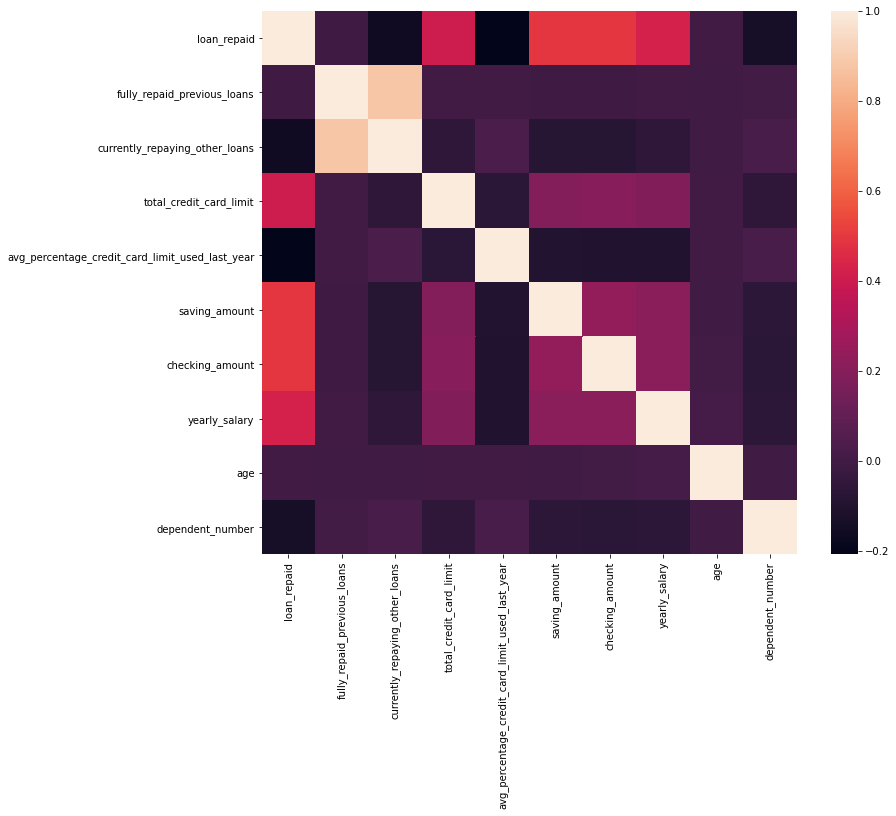

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), ax=ax)
plt.show()

## Modelling

### data preprocessing

In [24]:
# encoding 'loan_purpose'
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [27]:
# define categorical features
categorical_feature = ['loan_purpose',  'fully_repaid_previous_loans', 
                       'currently_repaying_other_loans']
target = 'loan_repaid'

data[categorical_feature] = data[categorical_feature].astype('category')
data[target] = data[target].astype('category')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   loan_purpose                                     47654 non-null  category
 1   loan_repaid                                      47654 non-null  category
 2   fully_repaid_previous_loans                      47654 non-null  category
 3   currently_repaying_other_loans                   47654 non-null  category
 4   total_credit_card_limit                          47654 non-null  int64   
 5   avg_percentage_credit_card_limit_used_last_year  47654 non-null  float64 
 6   saving_amount                                    47654 non-null  int64   
 7   checking_amount                                  47654 non-null  int64   
 8   yearly_salary                                    47654 non-null  int64   
 9   age             

In [30]:
# it's imbalanced so maybe we need to do under sampling or over sampling, here I used under sampling
data.loan_repaid.value_counts(normalize=True)

1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

In [107]:
# under sampling - generate sample of class 1 tyeps to match number of class 1 types
count1,count0 = data.loan_repaid.value_counts()
repaid = data[data.loan_repaid==1]
non_repaid = data[data.loan_repaid==0]
under1 = repaid.sample(count0)
model_dta = pd.concat([under1,non_repaid],axis = 0)
model_dta.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number
15851,0,1.0,-1.0,-1.0,7700,0.64,2587,3594,39300,36,0
97479,3,1.0,-1.0,-1.0,3500,0.73,1782,9200,15000,35,0
32386,0,1.0,1.0,0.0,6400,0.64,3204,3195,27800,53,1
25473,3,1.0,1.0,0.0,3700,0.78,3592,3567,24000,45,1
3097,1,1.0,1.0,0.0,3400,0.58,1494,3005,18000,29,4


In [108]:
model_dta.shape

(33896, 11)

In [109]:
model_dta.loan_repaid.value_counts()

1.0    16948
0.0    16948
Name: loan_repaid, dtype: int64

### train the decision tree model and get the performance evaluation

In [111]:
X = model_dta.drop(columns = 'loan_repaid')
y = model_dta['loan_repaid']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 1024, stratify = y)

In [112]:
# initial model
dtree = DecisionTreeClassifier(max_depth = 4, random_state = 1024)
dtree.fit(X_train,y_train)
yhat = dtree.predict(X_test)

In [114]:
score = dtree.score(X_test,y_test)
print('----------Accuracy----------')
print(round(score,2))
print('----------Performance-------')
print(classification_report(y_test,yhat))

----------Accuracy----------
0.89
----------Performance-------
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      4237
         1.0       0.96      0.82      0.89      4237

    accuracy                           0.89      8474
   macro avg       0.90      0.89      0.89      8474
weighted avg       0.90      0.89      0.89      8474



[[4111  126]
 [ 764 3473]]


<AxesSubplot:>

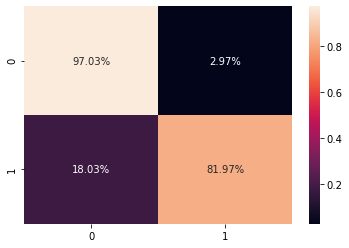

In [118]:
cf_matrix = confusion_matrix(y_test,yhat)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis = 1),annot=True,fmt='.2%')

In [119]:
# We will use AUC (Area Under Curve) as the evaluation metric. 
# Our target value is binary so it’s a binary classification problem.
# AUC is a good way for evaluation for this type of problems.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yhat)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8949728581543546

### choose the best parameter 

1. `max_depth` : 6

max_depth_train: 32.0
max_depth_test: 6.0


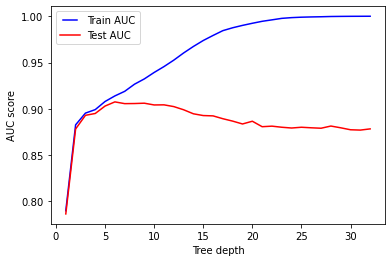

In [130]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state = 1024)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    if roc_auc>=max(train_results):
        train_max_d = max_depth
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    if roc_auc>=max(test_results):
        test_max_d = max_depth
print('max_depth_train:',train_max_d)
print('max_depth_test:',test_max_d)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

2. `min_samples_split`

It shows that `min_samples_split`<=0.5

min_samples_split_train: 0.5
min_samples_split_test: 0.5


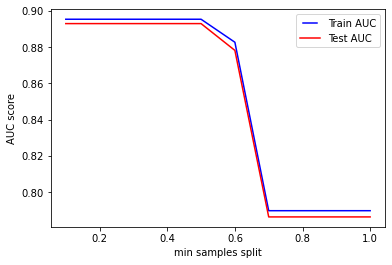

In [133]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    if roc_auc>=max(train_results):
        train_max_d = min_samples_split
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    if roc_auc>=max(test_results):
        test_max_d = min_samples_split

print('min_samples_split_train:',train_max_d)
print('min_samples_split_test:',test_max_d)
line1,= plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2,= plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

3. `min_samples_leaf`: 0.1

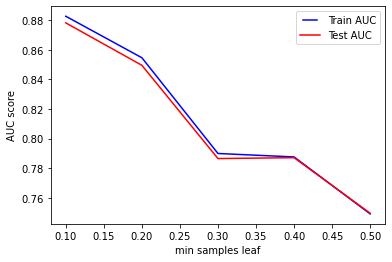

In [134]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs,train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs,test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

4. `max_features`

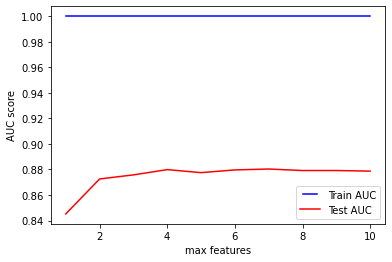

In [135]:
max_features = list(range(1,data.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(max_features=max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

### retrain the model according to the best parameters

Auc raised from 0.895 to 0.907 

----------Accuracy----------
0.91
----------Performance-------
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      4237
         1.0       0.95      0.86      0.90      4237

    accuracy                           0.91      8474
   macro avg       0.91      0.91      0.91      8474
weighted avg       0.91      0.91      0.91      8474

[[4047  190]
 [ 594 3643]]


<AxesSubplot:>

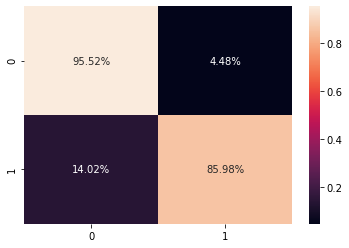

In [200]:
dtree = DecisionTreeClassifier(max_depth = 6, max_features = 10, random_state = 1024)
dtree.fit(X_train,y_train)
yhat = dtree.predict(X_test)

score = dtree.score(X_test,y_test)
print('----------Accuracy----------')
print(round(score,2))
print('----------Performance-------')
print(classification_report(y_test,yhat))

cf_matrix = confusion_matrix(y_test,yhat)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis = 1),annot=True,fmt='.2%')

In [146]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yhat)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9074817087561955

### feature importance

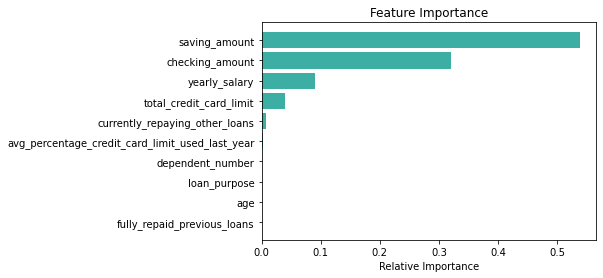

In [149]:
features = X.columns
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance')
plt.barh(range(len(indices)),importances[indices],color = '#3CAEA3', align = 'center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [162]:
data

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number
3,4,1.0,1.0,0.0,5400,0.52,3345,2764,15800,58,4
4,0,0.0,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4
6,0,1.0,1.0,0.0,7800,0.30,4206,4368,51100,51,2
7,1,0.0,0.0,1.0,4300,1.02,886,1597,15000,59,2
8,3,1.0,1.0,0.0,3900,0.65,1837,3795,12000,24,1
...,...,...,...,...,...,...,...,...,...,...,...
101094,0,0.0,1.0,1.0,2600,0.83,1019,537,37100,37,4
101095,1,0.0,1.0,0.0,2400,0.40,553,2372,37000,56,3
101096,0,0.0,-1.0,-1.0,3100,0.68,367,1957,22700,59,5
101097,4,1.0,-1.0,-1.0,4600,0.50,1134,1621,35200,49,1


## Questions

### Question 1

Build a model which is better than the bank model. For simplicity, assume that:

    - If you grant the loan and the it doesn't get repaid, you lose 1
    - If you grant the loan and the it does get repaid, you gain 1
    - If you don't grant the loan, you gain 0

In [218]:
# claculate bank profit
# equals to 0 since I did under sampling before to make the number of 0 equals to the number of 1
repaid = y_test.values.astype(int)
bank_profit = sum([-1 if i==0 else 1 for i in repaid])
bank_profit

0

In [206]:
def cal_profit(repaid, pred, threshold):
    '''calculate the profit'''
    profit = 0    
    loan_granted = (pred>threshold).astype(int)
    for i in range(len(repaid)):
        if loan_granted[i]:
            if repaid[i]==1:
                profit+=1
            else:
                profit-=1
    return profit

In [215]:
yhat_con = dtree.predict_proba(X_test)
yhat_con[:,1]

array([0.06257218, 1.        , 0.69456067, ..., 0.06257218, 0.06257218,
       0.06257218])

In [216]:
# calculate the profit according to given threshold
thresholds = list(np.linspace(0, 1, 100))
profits = []

for threshold in thresholds:
    profits.append(cal_profit(repaid, yhat_con[:,1], threshold))

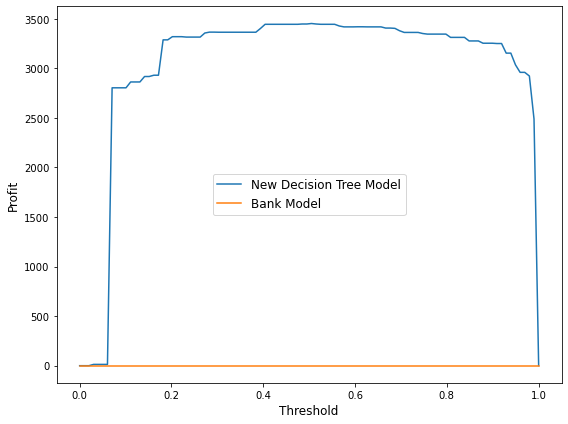

In [219]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, profits, label='New Decision Tree Model')
ax.plot(thresholds, [bank_profit] * len(thresholds), label='Bank Model')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [223]:
threshold_profits = pd.DataFrame({'threshold':thresholds,'profits':profits})
temp = threshold_profits.loc[ threshold_profits.profits.argmax(),:]
temp

threshold       0.505051
profits      3453.000000
Name: 50, dtype: float64

Clearly, the new model outperforms the original model used by the bank.

## Question 2

Describe the impact of the most important variables on the prediction. Also, focus on the variable `is_employed`, which describes whether the borrower is employed when she asks for the loan. How does this variable impact the model? Explain why

*Answer to question 2*

according to above plot, the most important feature is `saving amount`. This makes perfect sense. Money in the saving account, meaure a person's ability to control his financial situation. More money in the saving account, more likely the borrower can repay.

as I mentioned, in my model, `is_employed` is merged into feature `yearly_salary`, which correspond to the case 'yearly_salary=0'. according to above plot, yearly_salary is also a strong feature.

* if not employed, then yearly_salary=0, which will impact negatively on 'grant decision'. that is very easy to understand, a person without any financial input, will be very unlikely to repay.

* but even the person is employed, whether grant the loan or not, depends on his salary. higher salary indicates strong ability to repay.

## Question 3

Are there any other variables, not in the data provided, that you'd have liked to include in the model?

*Answer to question 3*

Some useful feature which may include:

* Marriage status.
    - Because even a borrow cannot repay, if he/she is married, his/her spouse can help to repay.
* Housing status, has his/her own house, or rent appartments? if renting, how much is monthly rent?
    - Because even the borrower cannot repay, if he/she has house, the house can be sold to repay the debt
* Educational level
    - Normally a person who received higher education, has stronger capability to earn money to repay, and has higher moral standard to repay.